# Statistical Learning Theory. Exam project
### Felipe Vaca

# Overview

This project aims to build an 'efficient' classifier for cannabis consumption based on several personality measurements (neuroticism, extraversion, openness to experience, agreeableness, conscientiousness, impulsivity, and sensation seeking. A further description and files of the 'Drug consumption (quantified) Data Set' can be found in:

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29

There is also a related paper (Fehrman et al., 2017). I will discuss some of their approaches and results.

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [42]:
# Load data
data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data'
drug_data = pd.read_csv(data_url, sep=',', header=None)

# Name features
drug_data.columns = ['id','age','gender','education','country','ethnicity','neuroticism','extraversion','openess','agreeableness','conscientiousness','impulsiveness','sensation','alcohol','amphet','amyl','benzos','caffeine','cannabis','chocolate','coke','crack','ecstasy','heroin','ketamine','legalh','lsd','meth','mushrooms','nicotine','semeron','vsa']
drug_data.drop(columns = ['semeron'], inplace = True)

drug_data.head(10)

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openess,agreeableness,...,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,...,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,...,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0
5,6,2.59171,0.48246,-1.22751,0.24923,-0.31685,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0
6,7,1.09449,-0.48246,1.16365,-0.57009,-0.31685,-0.46725,-1.09207,-0.45174,-0.30172,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0
7,8,0.49788,-0.48246,-1.73790,0.96082,-0.31685,-1.32828,1.93886,-0.84732,-0.30172,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0
8,9,0.49788,0.48246,-0.05921,0.24923,-0.31685,0.62967,2.57309,-0.97631,0.76096,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0
9,10,1.82213,-0.48246,1.16365,0.96082,-0.31685,-0.24649,0.00332,-1.42424,0.59042,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0


# Exploratory Data Analysis

### Target Variable
There are 18 variables related with consumption of legal or illegal drugs. They are categorical and their possible values are:

* CL0: Never Used 
* CL1: Used over a Decade 
* CL2: Used in Last Decade
* CL3: Used in Last Year  
* CL4: Used in Last Month
* CL5: Used in Last Week 
* CL6: Used in Last Day  

Each of those variables can be treated as the target variable separately. Before, building some classification models, Fehrman et al.(2017) recode those variables in 'users' and 'non-users groups' according to different criteria: _decade-based, year-based, month-based_, and  _week-based_. For example, in the _month based_ problem, the categories 'Used in last year', 'Used in last decade', 'Used over a decade ago', and 'Never used' are combined to form a group of non-users and all three other categories are placed into the group of users. 

I think the authors did the recoding because of the high imbalance of classes (see the figure and tables in the following two cells) and the potential low fit. Indeed, I tried to run some classification models (SVM, Random Forest, and Gradient Boosting, as in the next setion) using all the seven classes. My results were very poor, and some of them were due to overfitting. I don't present such results, because they can be easily displayed by setting 'cannabis' as the target variable, instead of 'is_user', in one of the cells below. 

All in all, I will adopt the _month-based_ criteria for recoding the feature 'cannabis'. The new feature will be used as the target variable.

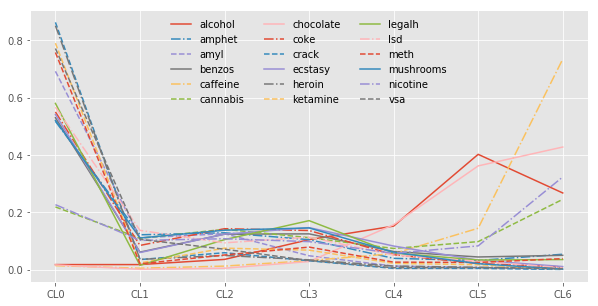

In [43]:
# Drug consumption variables
dv = ['alcohol','amphet','amyl','benzos','caffeine','cannabis','chocolate','coke','crack','ecstasy','heroin','ketamine','legalh','lsd','meth','mushrooms','nicotine','vsa']

# Relative frequencies plots for drug variables
plt.figure(figsize=(10,5))
for v in dv:
    p = np.where(dv == v)    
    linestyles = ['-','-.','--']
    i = np.where(np.array(dv) == v)[0][0]
    plt.plot(pd.crosstab(index=drug_data[v], columns="count")/drug_data.shape[0], linestyle = linestyles[i%3])
plt.legend(dv,loc= 'upper center',ncol=3,frameon=False)
plt.show()  

# It can be noted that the majority of drug consumption variables have concentration of observations 
# in CL0 category

In [44]:
# Frequencies of drug consumption variables
for v in dv:
    print(pd.crosstab(index=drug_data[v], columns="count")/drug_data.shape[0])


col_0       count
alcohol          
CL0      0.018037
CL1      0.018037
CL2      0.036074
CL3      0.105040
CL4      0.152255
CL5      0.402653
CL6      0.267905
col_0      count
amphet          
CL0     0.517772
CL1     0.122016
CL2     0.128912
CL3     0.105040
CL4     0.039788
CL5     0.032361
CL6     0.054111
col_0     count
amyl           
CL0    0.692308
CL1    0.111406
CL2    0.125729
CL3    0.048806
CL4    0.012732
CL5    0.007427
CL6    0.001592
col_0      count
benzos          
CL0     0.530504
CL1     0.061538
CL2     0.124138
CL3     0.125199
CL4     0.063660
CL5     0.044562
CL6     0.050398
col_0        count
caffeine          
CL0       0.014324
CL1       0.005305
CL2       0.012732
CL3       0.031830
CL4       0.056233
CL5       0.144828
CL6       0.734748
col_0        count
cannabis          
CL0       0.219098
CL1       0.109814
CL2       0.141114
CL3       0.111936
CL4       0.074271
CL5       0.098143
CL6       0.245623
col_0         count
chocolate          
CL0   

Additionally, Fehrman et al.(2017) considered the correlations between the usage of different drugs. The purpose is to identify groups of correlated variables (they call them _pleiades_) and perform classification tasks on such groups instead on individual variables. To indentify such groups they compute Pearson's correlation coefficient between the distribution of each pair of variables. As an alternative I run the Kolmogorov Smirnov Test among each pair of drug consumption variables to determine whether two one-dimensional probability distributions differ. My results partially match those of Fehrman et al.(2017). Thus I chose to run classification only on cannabis consumption.


In [45]:
# Kolmogorov Smirnov Test among drug consumption variables
import scipy.stats as stats
pval_ks =  np.zeros(shape=(len(dv),len(dv)))
for i in np.arange(0,len(dv)):
    for j in np.arange(0,len(dv)):
        ks, p = stats.ks_2samp(drug_data[dv[i]].value_counts(), drug_data[dv[j]].value_counts())
        pval_ks[i,j] = round(p,2)
        
pval_ks = pd.DataFrame(pval_ks)
pval_ks.index = dv
pval_ks.columns = dv
pval_ks

,alcohol,amphet,amyl,benzos,caffeine,cannabis,chocolate,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,vsa
alcohol,1.00,0.88,0.42,0.42,0.42,0.42,0.42,0.88,0.42,0.88,0.42,0.42,1.00,0.88,0.42,0.88,0.42,0.42
amphet,0.88,1.00,0.42,0.88,0.13,0.42,0.13,0.88,0.13,1.00,0.13,0.13,0.88,0.88,0.42,0.88,0.42,0.42
amyl,0.42,0.42,1.00,0.42,1.00,0.13,0.88,0.88,0.88,0.88,0.88,0.88,0.42,0.88,0.42,0.88,0.13,0.88
benzos,0.42,0.88,0.42,1.00,0.13,0.13,0.13,0.88,0.03,0.88,0.03,0.13,0.42,0.88,0.13,0.88,0.42,0.13
caffeine,0.42,0.13,1.00,0.13,1.00,0.03,0.88,0.88,0.42,0.42,0.88,0.88,0.42,0.88,0.42,0.42,0.03,0.88
cannabis,0.42,0.42,0.13,0.13,0.03,1.00,0.13,0.42,0.00,0.42,0.00,0.03,0.13,0.42,0.03,0.42,0.42,0.03
chocolate,0.42,0.13,0.88,0.13,0.88,0.13,1.00,0.88,0.88,0.42,0.88,0.88,0.42,0.42,0.42,0.88,0.13,0.88
coke,0.88,0.88,0.88,0.88,0.88,0.42,0.88,1.00,0.42,1.00,0.13,0.42,1.00,1.00,0.42,1.00,0.42,0.42
crack,0.42,0.13,0.88,0.03,0.42,0.00,0.88,0.42,1.00,0.13,0.42,0.88,0.42,0.42,0.42,0.13,0.03,0.88
ecstasy,0.88,1.00,0.88,0.88,0.42,0.42,0.42,1.00,0.13,1.00,0.13,0.42,0.88,1.00,0.42,1.00,0.42,0.42


Finally, I tried to observe relations between the categories of drug consumption variables. For this purpose, I used Multiple Correspondence Analysis (MCA). The usage of this tool is more straightforward in R than Python, so I opted by the former. Anyway, nothing so interesting (different from previous results) was found in 2-D projections, so I do not include the results,  but I copy the code below if you want to run it. Apologizes.


```{r}
library (FactoMineR)

drug_data <- read.csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00373/drug_consumption.data',header = F)

colnames(drug_data) <-  c('id','age','gender','education',
                           'country','ethnicity','neuroticism',
                          'extraversion','openess','agreeableness',
                          'conscientiousness','impulsiveness','sensation',
                          'alcohol','amphet','amyl',
                          'benzos','caffeine','cannabis',
                          'chocolate','coke','crack',
                          'ecstasy','heroin','ketamine',
                          'legalh','lsd','meth','mushrooms',
                          'nicotine','semeron','vsa')

drug_data <- drug_data[,-(ncol(drug_data)-1)]

head(drug_data)

variables_mca <- colnames(drug_data)[14:ncol(drug_data)]

res.mca<- MCA(drug_data[,variables_mca],graph = FALSE)

windows()

plot.MCA(res.mca, invisible=c("ind"), cex=0.7,col.var = "blue",title="")

summary(res.mca)
```

In [46]:
# recode target variable
drug_data['is_user'] = drug_data['cannabis']
user_code = {'CL0':'N', 'CL1':'N', 'CL2':'N','CL3':'N','CL4':'U','CL5':'U','CL6':'U'}
drug_data.replace(dict(is_user = user_code), inplace = True) 

### Input features
Originally, all the input features were categorical. Fehrman et al.(2017) claim that because of the big amount of dummy variables required, they transformed such features to work with continuous data. On one hand,
ordinal features (personality measurements) were quantified by means of polychoric coefficients; on the other, nominal features (demographic attributes) were quantified by means of Categorical Principal Component Analysis. 

For this project, I have not considered the demographic attributes. First, because I am not interested in them; Second, because I don't see the logic behid quantifying nominal attributes. There is no order in the original attributes, there is order in the transformed ones. Furthermore, the transformed attributes cannot be treated as continuous because there are few possible values in each of them, i.e, despite the quantification, the demographic attributes are still discrete.

In order to have a first idea about the separability of classes and presence of redundant information on the input features, I observed scatterplots and correlation matrix (see the following three cells). The results suggest that: 1) classes are not linearly separable in 1-D nor 2-D spaces, and 2) there are no 'strong' relations among input features, then all of them will be considered for the classification task. 


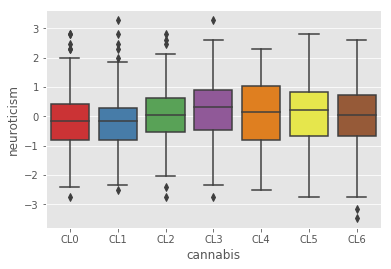

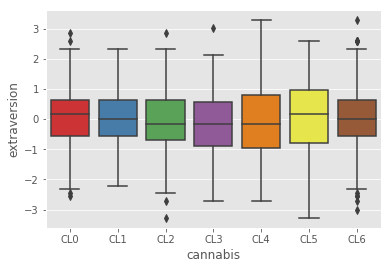

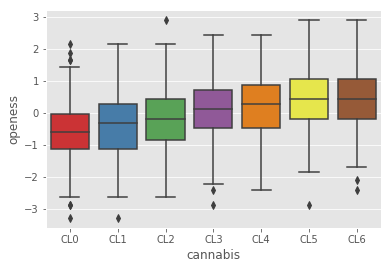

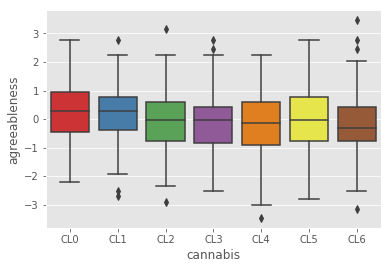

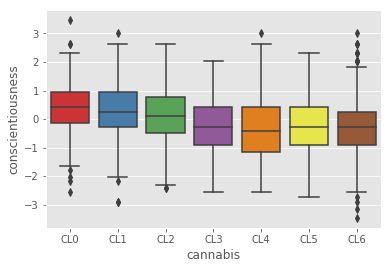

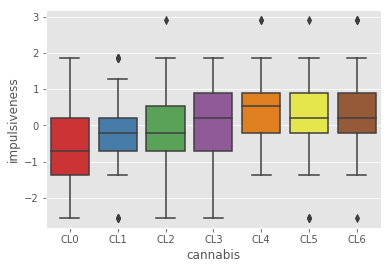

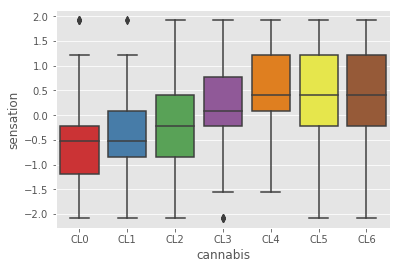

In [47]:
import seaborn as sns
# input features
iv = drug_data.columns[6:13]
# Grouped boxplot
for v in iv:
    sns.boxplot(x="cannabis", y = v, data=drug_data, palette="Set1", order= ['CL0','CL1','CL2','CL3','CL4','CL5','CL6'])
    plt.show()


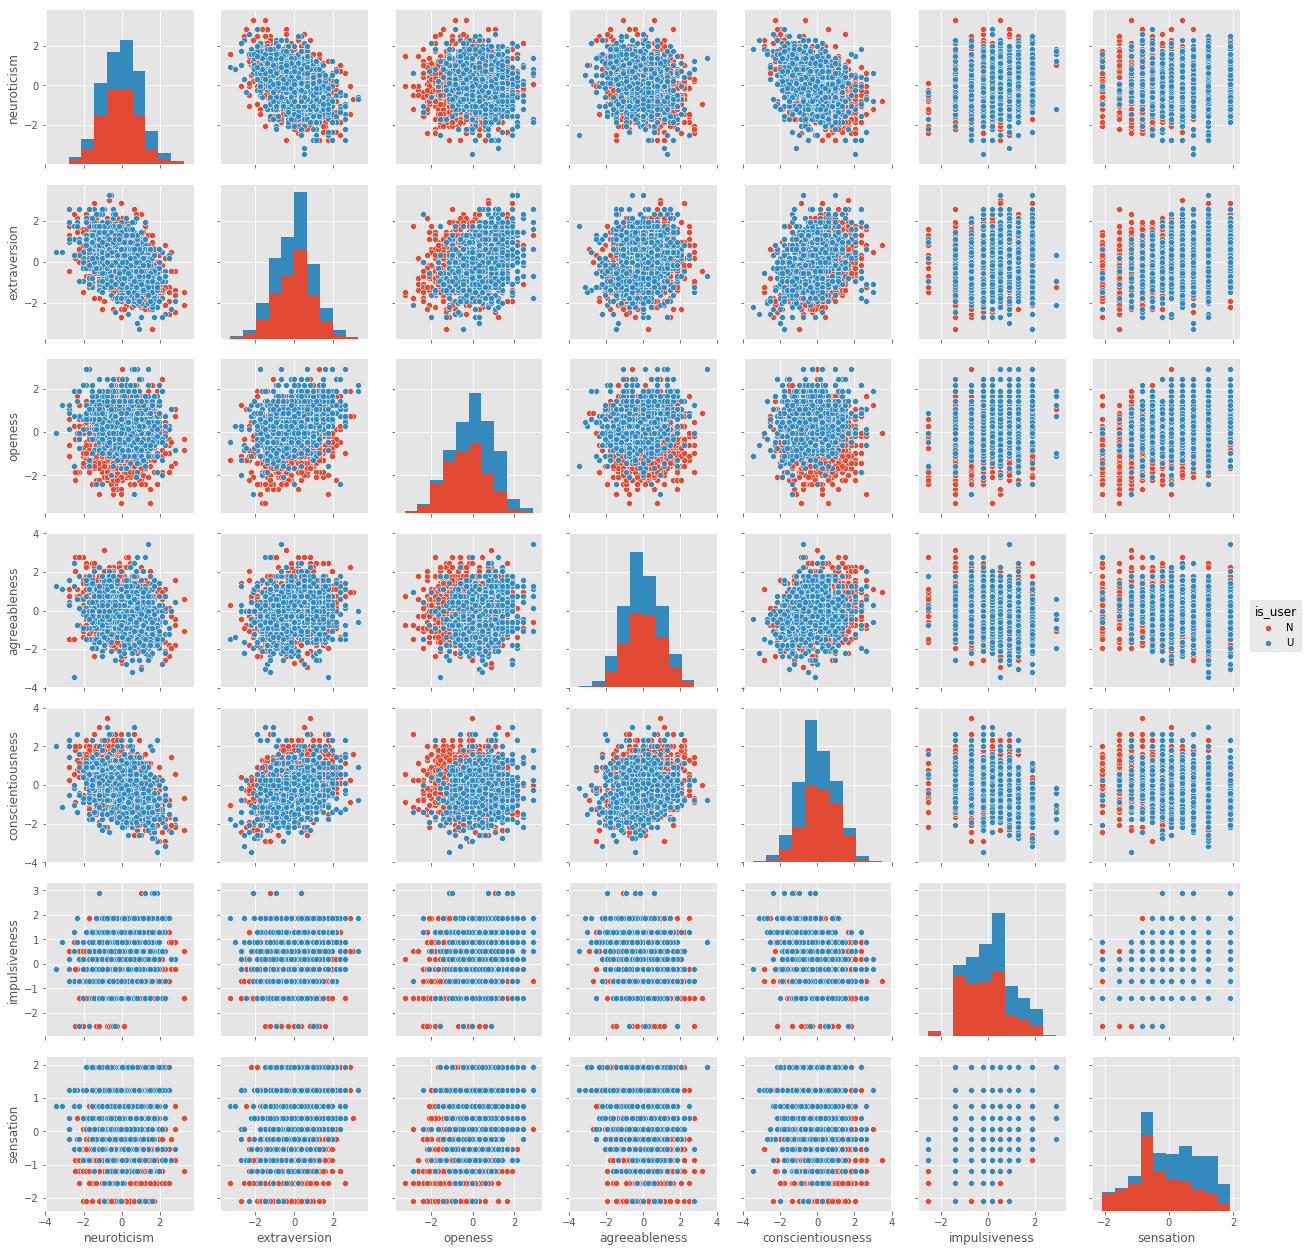

In [48]:
# pairplot
sns.pairplot(drug_data[drug_data.columns[6:13].append(drug_data.columns[-1:])], hue = 'is_user')

# For all except two input features, their distributions seem symmetric. 
# Indeed, those two features seem discrete

In [49]:
# Correlation among input features
round(drug_data[iv].corr(),3)

,neuroticism,extraversion,openess,agreeableness,conscientiousness,impulsiveness,sensation
neuroticism,1.000,-0.431,0.010,-0.217,-0.391,0.174,0.080
extraversion,-0.431,1.000,0.245,0.157,0.308,0.114,0.210
openess,0.010,0.245,1.000,0.039,-0.057,0.278,0.422
agreeableness,-0.217,0.157,0.039,1.000,0.247,-0.230,-0.208
conscientiousness,-0.391,0.308,-0.057,0.247,1.000,-0.335,-0.229
impulsiveness,0.174,0.114,0.278,-0.230,-0.335,1.000,0.623
sensation,0.080,0.210,0.422,-0.208,-0.229,0.623,1.000


# Classification models

The input variables are not standardized because they have similar distribution (as shown previously);  similar mean, standard deviation, minimum, and maximum (as shown in the cell below); and they indeed seem normalized. Additionally, there is no missing data. For these reasons no further preprocessing is done on input variables.

In [50]:
drug_data[iv].describe()

,neuroticism,extraversion,openess,agreeableness,conscientiousness,impulsiveness,sensation
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


As mentioned, the target variable (cannabis consumption) is recoded on a _month-based_ criteria. The new categories are: User (U) and Non User (N).

In [51]:
# set data for models
X = drug_data[iv] # Input features
y = drug_data['is_user'] # target variable

# make train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=10)

In [52]:
# load some useful functions
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  

## SVM

In [53]:
from sklearn.svm import SVC 

### Best model
The search of the best model will be based on the  penalty parameter C of the error term. I have read that 'The default for C is the inverse of the empirical variance $s^2$', which in the case of standardized variables is 1. I have used values C = $2^{k}$, for k $\in [-2,2]$, as suggested in: 
https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters
and
http://www.gatsby.ucl.ac.uk/aistats/fullpapers/198.pdf

In [54]:
# Initialize the validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# candidate values of C
C_s = np.logspace(-2, 2, 10, base = 2)
# candidate kernels
kernels = ['linear', 'rbf', 'sigmoid', 'poly']

# Train on the training set
for k in kernels:
    # Create lists to save the values of accuracy on training and test sets
    train_acc = []
    test_acc = []

    for C in C_s:
        svclassifier = SVC(kernel= k, random_state=42)
        temp_train_acc = []
        temp_test_acc = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            svclassifier.fit(X_train, y_train) 
            temp_train_acc.append(svclassifier.score(X_train, y_train))
            temp_test_acc.append(svclassifier.score(X_test, y_test))
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
    train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
    print(str(k)+": Best accuracy on CV is {:.2f}% with {} C".format(max(test_acc.mean(axis=1))*100, 
                                                            C_s[np.argmax(test_acc.mean(axis=1))]))

linear: Best accuracy on CV is 73.21% with 0.25 C
rbf: Best accuracy on CV is 73.26% with 0.25 C
sigmoid: Best accuracy on CV is 62.44% with 0.25 C
poly: Best accuracy on CV is 66.26% with 0.25 C


The 'best' kernel is RBF kernel, but there is no much difference with linear kernel. Thus, for simplicity, I chose the latter.

In [55]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear', C = 0.25)  
svclassifier.fit(X_train, y_train)  

SVC(C=0.25, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [56]:
# get predicted class on test set
y_pred = svclassifier.predict(X_test)  

In [57]:
# evaluation metrics
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[167  52]
 [ 43 114]]
             precision    recall  f1-score   support

          N       0.80      0.76      0.78       219
          U       0.69      0.73      0.71       157

avg / total       0.75      0.75      0.75       376



## Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

### Best model

In [59]:
# Initialize the validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to save the values of accuracy on training and test sets
train_acc = []
test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

# Train on the training set
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True,max_depth = 10)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(max(test_acc.mean(axis=1))*100, 
                                                        trees_grid[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 70.66% with 75 trees


Text(0.5,0,'N_estimators')

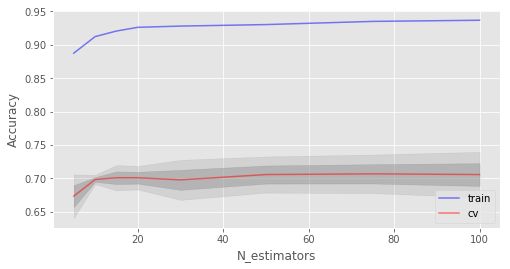

In [60]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

In [61]:
random_forest = RandomForestClassifier(n_estimators=75, criterion='gini', max_features='sqrt', 
                                       n_jobs=-1, random_state=42, bootstrap=True, max_depth=10)
random_forest.fit(X_train, y_train)
rf_predict = random_forest.predict(X_test)

In [62]:
# evaluation metrics
print(confusion_matrix(y_test,rf_predict))  
print(classification_report(y_test,rf_predict)) 

[[166  53]
 [ 58  99]]
             precision    recall  f1-score   support

          N       0.74      0.76      0.75       219
          U       0.65      0.63      0.64       157

avg / total       0.70      0.70      0.70       376



Finally, there are two variables who clearly discriminate more than the rest: openness to experience and sensation seeking. According to Fehrman et al.(2017), the first one, is related with general appreciation for art, unusual ideas, and imaginative, creative, unconventional, and wide interests. The second one is related with disinhibition and thrill and adventure seeking (Kopstein et al., 2001).
These results are coherent with what is expected from common knowledge about recreational drugs, which include cannabis. 

In [63]:
# Features importance
for i, c in enumerate(X.columns):
     print(c + ': ' + '%.4f' % random_forest.feature_importances_[i])

neuroticism: 0.1234
extraversion: 0.1139
openess: 0.2065
agreeableness: 0.1117
conscientiousness: 0.1466
impulsiveness: 0.0901
sensation: 0.2078


## Gradient Boosting

In [64]:
from sklearn.ensemble import GradientBoostingClassifier

### Best model

In [65]:
features = {"f1":"neuroticism",
"f2":"extraversion",
"f3":"openess",
"f4":"agreeableness",
"f5":"conscientiousness",
"f6":"impulsiveness",
"f7":"sensation"}

The search best model is based on the number of boosting stages to perform. Scikit-learn references claim that 'Gradient boosting is fairly robust to over-fitting so a large number (of boosting stages) usually results in better performance'. At the same time, I will try to confirm such claim. 

In [66]:
# Initialize the validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create lists to save the values of accuracy on training and test sets
train_acc = []
test_acc = []
n_stages = [5, 10, 15, 20, 30, 50, 75, 100,200,500, 1000]

# Train on the training set
for n_stage in n_stages:
    gradient_boosting = GradientBoostingClassifier(learning_rate=.01, n_estimators=n_stage, max_depth=10, subsample=.6, max_features=None, random_state=42)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        gradient_boosting.fit(X, y)
        temp_train_acc.append(gradient_boosting.score(X_train, y_train))
        temp_test_acc.append(gradient_boosting.score(X_test, y_test))
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)
    
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} stages".format(max(test_acc.mean(axis=1))*100, 
                                                        n_stages[np.argmax(test_acc.mean(axis=1))]))

Best accuracy on CV is 100.00% with 500 stages


Looking at the best accuracy on CV I think I made a mistake. I used Google a bit and found this post:
https://stackoverflow.com/questions/48697770/xgboost-model-consistently-obtaining-100-accuracy
(at least now I know that there are at least two people who may have made a mistake on such kind of models).

I also ploted the improvement in loss on out-of-bag samples and the improvement on the in-bag sample, and observerd some evaluation metrics (see the following cells), but I did not find anything wrong.

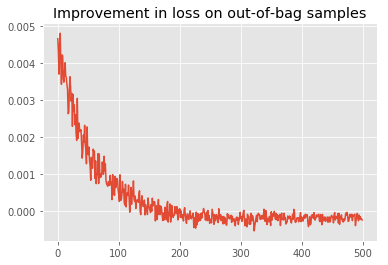

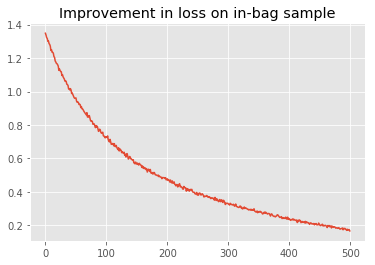

In [67]:
# Running the model with 'the best' number of boosting stages 
gradient_boosting = GradientBoostingClassifier(learning_rate=.01, n_estimators=500, max_depth=10, subsample=.6, max_features=None, random_state=42)
gradient_boosting.fit(X, y)

# improvement in loss on out-of-bag samples
plt.plot(np.arange(len(gradient_boosting.oob_improvement_)), gradient_boosting.oob_improvement_)
plt.title('Improvement in loss on out-of-bag samples')
plt.show()
# improvement in loss on in-bag sample
plt.plot(np.arange(len(gradient_boosting.train_score_)), gradient_boosting.train_score_)
plt.title('Improvement in loss on in-bag sample')
plt.show()

In [68]:
# get predicted class on test set
y_pred = gradient_boosting.predict(X_test)  

In [69]:
# evaluation metrics
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[219   0]
 [  0 157]]
             precision    recall  f1-score   support

          N       1.00      1.00      1.00       219
          U       1.00      1.00      1.00       157

avg / total       1.00      1.00      1.00       376



There is no clear difference among the feature importances. It can be noted that these results partially match those obtained with Random Forest Classifier. In particular, openess to experience is of the most important attributes, while impulsiveness is the least important attribute.

Feature ranking:
1. neuroticism 0.166497 
2. openess 0.163609 
3. conscientiousness 0.157491 
4. extraversion 0.148828 
5. agreeableness 0.146654 
6. sensation 0.126952 
7. impulsiveness 0.089969 


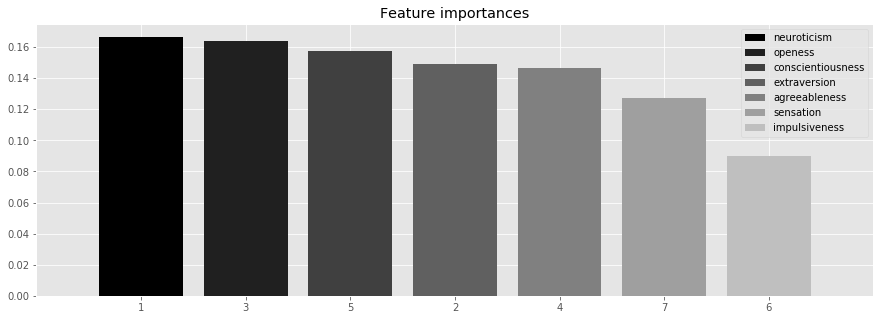

In [70]:
# Features importance
importances = gradient_boosting.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = len(iv)
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
            features["f"+str(feature_indices[f])], 
            importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title("Feature importances")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

## Conclusion

The best classifier for cannabis consumption based on several personality measurements was Gradient Boosting Classifier. The coresponding results outperform those obtained in Fehrman et al.(2017) (e.g., see Table 18). Additionally, those authors expected that drug usage is associated with high _Neuroticism (N)_, and low _Agreeableness (A)_ and _Conscientiousness (C)_; which are descriptors of the 'darker dimension of personality'. This claim is not confirmed in our case (see the cell below). Nevertheless, there is some agreement with their results in the sense that both findings suggest that _Openess to experience_ is higher for drug users.


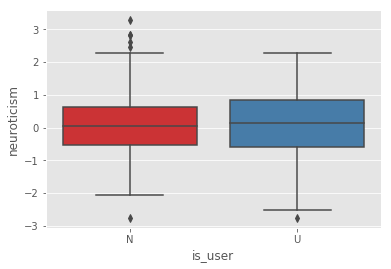

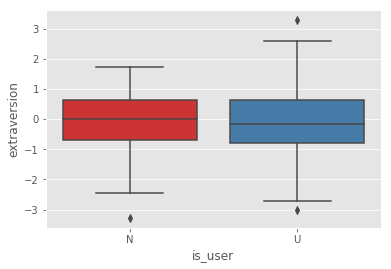

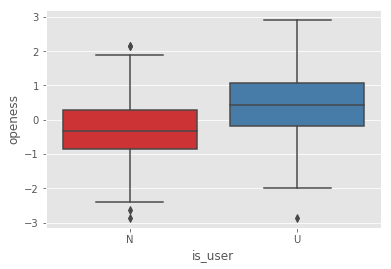

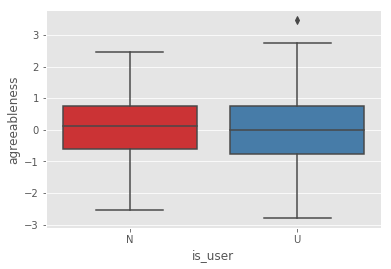

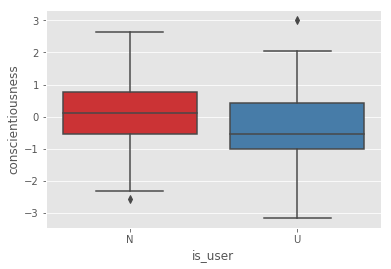

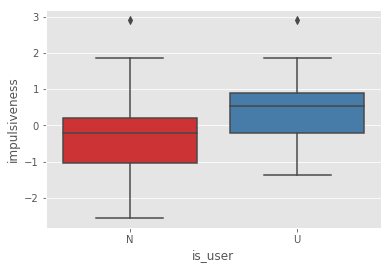

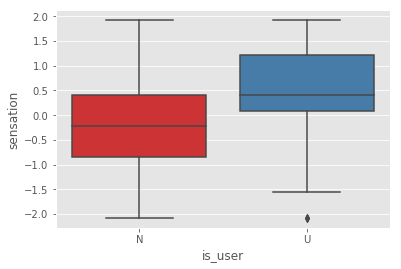

In [71]:
data_drug_test = X_test
data_drug_test['is_user'] = y_pred # predictions obtained with Gradien Boosting classifier

# Boxplots of input features grouped by predicted class
for v in iv:
    sns.boxplot(x="is_user", y = v, data=data_drug_test, palette="Set1")
    plt.show()